In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [6]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [101]:
#only not null, not zero and less that 10 hours to solve
df = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 36000) & (df['Respond to Available']!=0)]

In [102]:
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df1 = df.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm', 'Minutes',
                      'Supervisor District', 'Neighborhooods - Analysis Boundaries', 'Original Priority',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay', 'Weekofyear',  
                      'RowID', 'Battalion', 'ALS Unit', 'Fire Prevention District'], errors='ignore')

In [103]:
df1 = df1.dropna(how='any') 

In [105]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [106]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1432349 entries, 1 to 1650123
Data columns (total 10 columns):
Call Type                         1432349 non-null object
Zipcode of Incident               1432349 non-null int64
Station Area                      1432349 non-null object
Box                               1432349 non-null float64
Number of Alarms                  1432349 non-null int64
Unit Type                         1432349 non-null object
Unit sequence in call dispatch    1432349 non-null int64
Call to Dispatch                  1432349 non-null float64
Hours                             1432349 non-null int64
Hospital or Transport             1432349 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 120.2+ MB


In [107]:
cat_features=[
    0,
    2,
    5
]

In [108]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [109]:
model = CatBoostRegressor(iterations=300, depth=5,learning_rate=0.05)
model.fit(train_pool)

0:	learn: 2095.4339496	total: 956ms	remaining: 4m 45s
1:	learn: 2021.9027443	total: 1.79s	remaining: 4m 26s
2:	learn: 1953.1399567	total: 2.6s	remaining: 4m 17s
3:	learn: 1888.9184846	total: 3.11s	remaining: 3m 50s
4:	learn: 1829.0197027	total: 3.57s	remaining: 3m 30s
5:	learn: 1771.5997317	total: 4.23s	remaining: 3m 27s
6:	learn: 1718.1285201	total: 4.87s	remaining: 3m 23s
7:	learn: 1668.3736767	total: 5.53s	remaining: 3m 21s
8:	learn: 1622.1680543	total: 6.21s	remaining: 3m 20s
9:	learn: 1579.4009023	total: 6.91s	remaining: 3m 20s
10:	learn: 1539.6196220	total: 7.48s	remaining: 3m 16s
11:	learn: 1502.8172124	total: 8s	remaining: 3m 12s
12:	learn: 1468.8949324	total: 8.65s	remaining: 3m 10s
13:	learn: 1437.4354289	total: 9.23s	remaining: 3m 8s
14:	learn: 1408.4230978	total: 9.75s	remaining: 3m 5s
15:	learn: 1381.8169979	total: 10.3s	remaining: 3m 2s
16:	learn: 1357.1725705	total: 10.9s	remaining: 3m
17:	learn: 1334.6621738	total: 11.4s	remaining: 2m 58s
18:	learn: 1313.8620663	total: 

149:	learn: 1057.7760811	total: 1m 48s	remaining: 1m 48s
150:	learn: 1057.7133464	total: 1m 48s	remaining: 1m 47s
151:	learn: 1057.6073244	total: 1m 49s	remaining: 1m 46s
152:	learn: 1057.4740547	total: 1m 50s	remaining: 1m 45s
153:	learn: 1057.3857222	total: 1m 50s	remaining: 1m 45s
154:	learn: 1057.3077091	total: 1m 51s	remaining: 1m 44s
155:	learn: 1057.2350574	total: 1m 52s	remaining: 1m 43s
156:	learn: 1057.1673959	total: 1m 52s	remaining: 1m 42s
157:	learn: 1057.1185122	total: 1m 53s	remaining: 1m 42s
158:	learn: 1057.0105220	total: 1m 54s	remaining: 1m 41s
159:	learn: 1056.8007306	total: 1m 55s	remaining: 1m 40s
160:	learn: 1056.6840059	total: 1m 55s	remaining: 1m 40s
161:	learn: 1056.5946959	total: 1m 56s	remaining: 1m 39s
162:	learn: 1056.3077800	total: 1m 57s	remaining: 1m 38s
163:	learn: 1056.1778354	total: 1m 58s	remaining: 1m 37s
164:	learn: 1056.0138408	total: 1m 58s	remaining: 1m 37s
165:	learn: 1055.8357491	total: 1m 59s	remaining: 1m 36s
166:	learn: 1055.7688647	total:

296:	learn: 1046.3537990	total: 3m 43s	remaining: 2.25s
297:	learn: 1046.2585758	total: 3m 43s	remaining: 1.5s
298:	learn: 1046.2191398	total: 3m 44s	remaining: 752ms
299:	learn: 1046.1861409	total: 3m 45s	remaining: 0us


In [110]:
model.score(test_pool, y_test)  #

1029.957879576215

In [111]:
pred = model.predict(test_pool)

In [112]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(5)

,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Call to Dispatch,Hours,Hospital or Transport,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1650124,Medical Incident,94121,31,7164.0,1,ENGINE,1,87.0,15,0,936.0,813.385840,122.614160,1.503423e+04,1445.821015,-509.821015
1650125,Medical Incident,94121,31,7164.0,1,MEDIC,2,87.0,15,1,3200.0,3458.505322,-258.505322,6.682500e+04,1445.821015,1754.178985
1650126,Medical Incident,94102,1,1365.0,1,RESCUE SQUAD,3,81.0,15,0,156.0,311.491169,-155.491169,2.417750e+04,1445.821015,-1289.821015
1650127,Medical Incident,94103,1,2251.0,1,MEDIC,1,160.0,15,1,4081.0,3056.071620,1024.928380,1.050478e+06,1445.821015,2635.178985
1650128,Medical Incident,94103,1,2251.0,1,ENGINE,2,160.0,15,0,150.0,548.082912,-398.082912,1.584700e+05,1445.821015,-1295.821015


In [113]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [114]:
mae

619.513636006284

In [115]:
mse

1060813.233701133

In [116]:
rmse

1029.957879576215

In [117]:
determanation_score

0.630362785452057

In [27]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1328.754065952152
mse_mean: 3049596.3950702916
mrse_mean: 1746.309364079083


In [118]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Call Type', 3.2769606462104446),
 ('Zipcode of Incident', 1.080816505923575),
 ('Station Area', 1.2331958428005563),
 ('Box', 1.993873247233903),
 ('Number of Alarms', 15.725346886967348),
 ('Unit Type', 9.300038941313451),
 ('Unit sequence in call dispatch', 3.3511860570703456),
 ('Call to Dispatch', 1.3205100353789059),
 ('Hours', 1.858109898879475),
 ('Hospital or Transport', 60.85996193822199)]

[('Battalion', 0.5078027445356504),
 ('Station Area', 6.135001357254266),
 ('Box', 9.114046028348575),
 ('Original Priority', 1.9631004892661137),
 ('ALS Unit', 0.8674294353822795),
 ('Call Type Group', 3.333459641176911),
 ('Unit Type', 41.73743300645736),
 ('Fire Prevention District', 1.5738692854230882),
 ('Supervisor District', 1.5693252610655513),
 ('Month', 0.5003596981995669),
 ('WeekDay', 0.7519625648056559),
 ('Weekofyear', 1.623724419771495),
 ('Hours', 8.179958110857296),
 ('Minutes', 1.0530441606569498),
 ('Call Type Merged', 21.08948379679924)]
 
 [('Station Area', 6.994516107181966),
 ('Box', 5.876354709490432),
 ('Original Priority', 0.9627007503785607),
 ('Call Type Group', 1.29599635276719),
 ('Unit Type', 60.51084666020504),
 ('Fire Prevention District', 0.3122714646717646),
 ('Supervisor District', 0.5588749902917611),
 ('Weekofyear', 0.0),
 ('Hours', 3.0604472528149556),
 ('Minutes', 0.0),
 ('Call Type Merged', 20.427991712198327)]

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

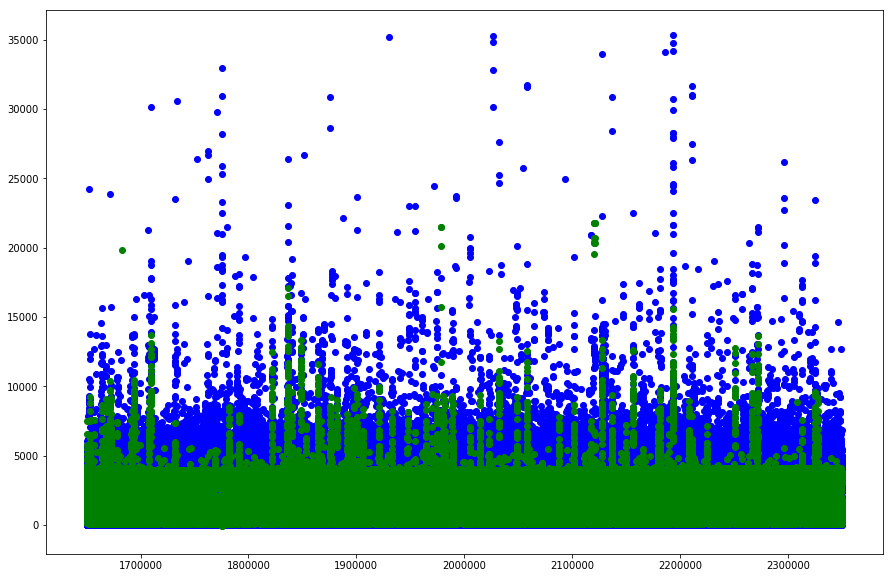

In [119]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

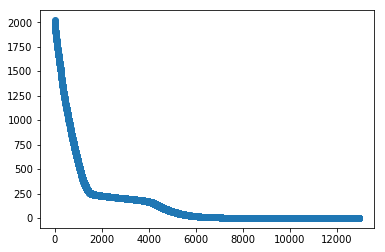

In [47]:
plt.scatter(range(0,12957), df1['Respond to Available'].value_counts())

In [100]:
df1[df1['Respond to Available']> 36000].count()  #2046293

Call Type                         49
Zipcode of Incident               49
Station Area                      49
Box                               49
Number of Alarms                  49
Unit Type                         49
Unit sequence in call dispatch    49
Fire Prevention District          49
Respond to Available              49
Call to Dispatch                  49
Hours                             49
Hospital or Transport             49
dtype: int64

###### df1[df['Respond to Available']==0]